<h1> CREAZIONE MODELLO SARIMA FRANCIA

In [1]:
import pandas as pd
df = pd.read_csv('../../csv/nazioni/serie_storica_fr.csv')
df.head()

,TIME,GEO,Value
0,2015-01-05,France,12986
1,2015-01-12,France,13364
2,2015-01-19,France,13006
3,2015-01-26,France,12830
4,2015-02-02,France,13497


In [2]:
df['TIME'] = pd.to_datetime(df['TIME'])

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   TIME    300 non-null    datetime64[ns]
 1   GEO     300 non-null    object        
 2   Value   300 non-null    int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 7.2+ KB


In [4]:
df=df.set_index('TIME')
df.head()

,GEO,Value
TIME,,
2015-01-05,France,12986
2015-01-12,France,13364
2015-01-19,France,13006
2015-01-26,France,12830
2015-02-02,France,13497


<h3>Creazione serie storica dei decessi totali 

In [5]:
ts = df.Value
ts.head()

TIME
2015-01-05    12986
2015-01-12    13364
2015-01-19    13006
2015-01-26    12830
2015-02-02    13497
Name: Value, dtype: int64

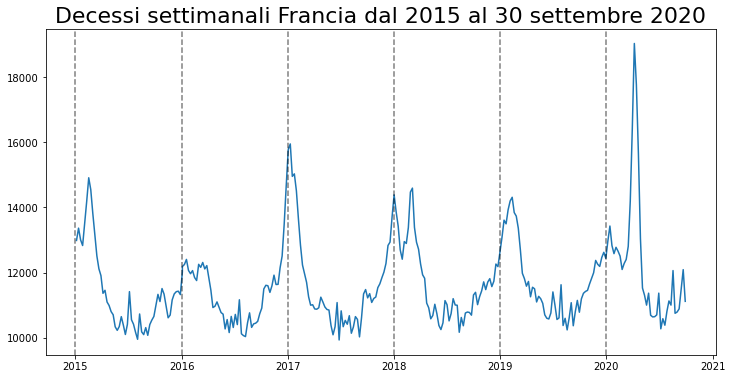

In [6]:
from datetime import datetime
from datetime import timedelta
start_date = datetime(2015,1,1)
end_date = datetime(2020,9,30)
lim_ts = ts[start_date:end_date]

#visulizzo il grafico
import matplotlib.pyplot as plt
plt.figure(figsize=(12,6))
plt.title('Decessi settimanali Francia dal 2015 al 30 settembre 2020', size=22)
plt.plot(lim_ts)
for year in range(start_date.year,end_date.year+1):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.5)

<h3>Decomposizione

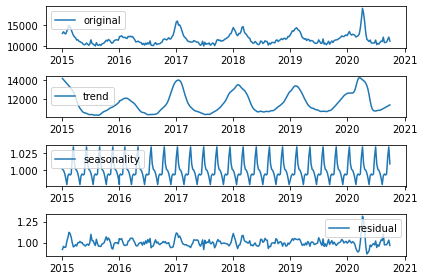

In [7]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(ts, period=12, two_sided=True, extrapolate_trend=1, model='multiplicative')

ts_trend = decomposition.trend #andamento della curva
ts_seasonal = decomposition.seasonal #stagionalità 
ts_residual = decomposition.resid #parti rimanenti
plt.subplot(411)
plt.plot(ts,label='original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(ts_trend,label='trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(ts_seasonal,label='seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(ts_residual,label='residual')
plt.legend(loc='best')
plt.tight_layout()

<h3>Test di stazionarietà

In [8]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=365).mean()
    rolstd = timeseries.rolling(window=365).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
    
    critical_value = dftest[4]['5%']
    test_statistic = dftest[0]
    alpha = 1e-3
    pvalue = dftest[1]
    if pvalue < alpha and test_statistic < critical_value:  # null hypothesis: x is non stationary
        print("X is stationary")
        return True
    else:
        print("X is not stationary")
        return False
        

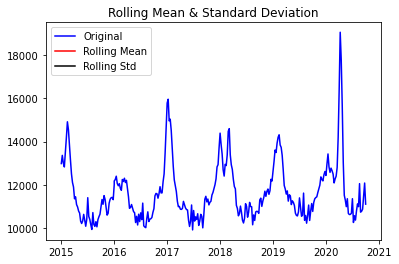

Results of Dickey-Fuller Test:
Test Statistic                  -3.536979
p-value                          0.007087
#Lags Used                       0.000000
Number of Observations Used    299.000000
Critical Value (1%)             -3.452411
Critical Value (5%)             -2.871255
Critical Value (10%)            -2.571947
dtype: float64
X is not stationary


False

In [9]:
test_stationarity(ts)

<h3>Suddivisione in Train e Test

<b>Train</b>: da gennaio 2015 a ottobre 2019; <br />
<b>Test</b>: da ottobre 2019 a dicembre 2019.

In [10]:
from datetime import datetime
train_end = datetime(2019,10,31)
test_end = datetime (2019,12,31)
covid_end = datetime(2020,8,30)


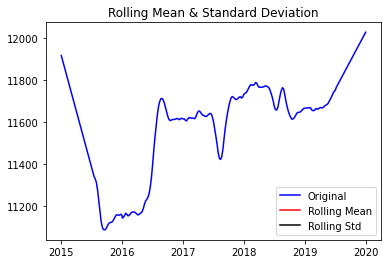

Results of Dickey-Fuller Test:
Test Statistic                  -1.320404
p-value                          0.619787
#Lags Used                       7.000000
Number of Observations Used    253.000000
Critical Value (1%)             -3.456464
Critical Value (5%)             -2.873033
Critical Value (10%)            -2.572895
dtype: float64
X is not stationary


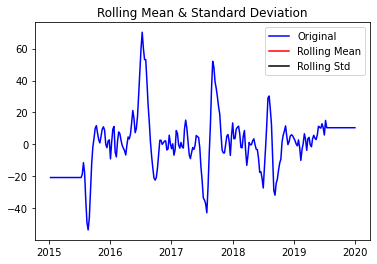

Results of Dickey-Fuller Test:
Test Statistic                  -3.895863
p-value                          0.002066
#Lags Used                       6.000000
Number of Observations Used    253.000000
Critical Value (1%)             -3.456464
Critical Value (5%)             -2.873033
Critical Value (10%)            -2.572895
dtype: float64
X is not stationary


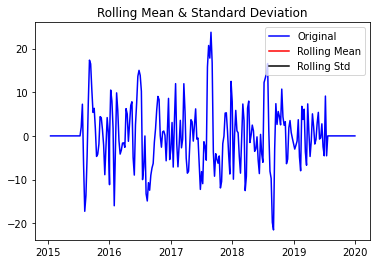

Results of Dickey-Fuller Test:
Test Statistic                -8.255477e+00
p-value                        5.251481e-13
#Lags Used                     7.000000e+00
Number of Observations Used    2.510000e+02
Critical Value (1%)           -3.456674e+00
Critical Value (5%)           -2.873125e+00
Critical Value (10%)          -2.572944e+00
dtype: float64
X is stationary
2


In [11]:
from dateutil.relativedelta import *
tsb = ts[:test_end]
decomposition = seasonal_decompose(tsb, period=52, two_sided=True, extrapolate_trend=1, model='multiplicative')

tsb_trend = decomposition.trend #andamento della curva
tsb_seasonal = decomposition.seasonal #stagionalità 
tsb_residual = decomposition.resid #parti rimanenti


tsb_diff = pd.Series(tsb_trend)
d = 0
while test_stationarity(tsb_diff) is False:
    tsb_diff = tsb_diff.diff().dropna()
    d = d + 1
print(d)

#TEST: dal 01-01-2015 al 31-10-2019
train = tsb[:train_end]

#TRAIN: dal 01-11-2019 al 31-12-2019
test = tsb[train_end + relativedelta(months=+1): test_end]

<h3>Grafici di Autocorrelazione e Autocorrelazione Parziale

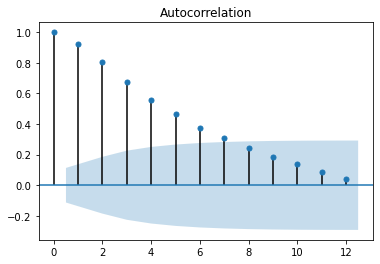

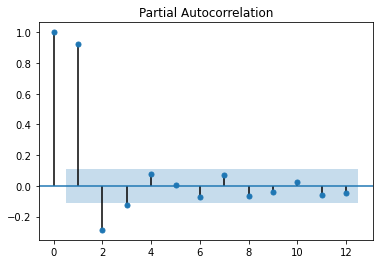

In [12]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(ts, lags =12)
plot_pacf(ts, lags =12)
plt.show()

<h2>Creazione del modello SARIMA sul Train

In [14]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(train, order=(52,0,2))
model_fit = model.fit()
print(model_fit.summary())

c:\users\monta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
c:\users\monta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date i

                              ARMA Model Results                              
Dep. Variable:                  Value   No. Observations:                  252
Model:                    ARMA(12, 2)   Log Likelihood               -1865.198
Method:                       css-mle   S.D. of innovations            393.847
Date:                Sun, 13 Dec 2020   AIC                           3762.396
Time:                        17:33:00   BIC                           3818.867
Sample:                             0   HQIC                          3785.119
                                                                              
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const         1.154e+04     86.614    133.269      0.000    1.14e+04    1.17e+04
ar.L1.Value      2.8232        nan        nan        nan         nan         nan
ar.L2.Value     -2.6632        nan        na

c:\users\monta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\arima_model.py:1521: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(-inv(hess)))


<h4>Verifica della stazionarietà dei residui del modello ottenuto

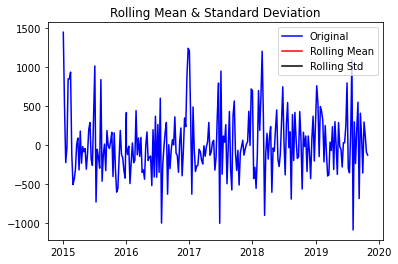

Results of Dickey-Fuller Test:
Test Statistic                -1.583776e+01
p-value                        9.773437e-29
#Lags Used                     0.000000e+00
Number of Observations Used    2.510000e+02
Critical Value (1%)           -3.456674e+00
Critical Value (5%)           -2.873125e+00
Critical Value (10%)          -2.572944e+00
dtype: float64
X is stationary


True

In [15]:
residuals = model_fit.resid
test_stationarity(residuals)

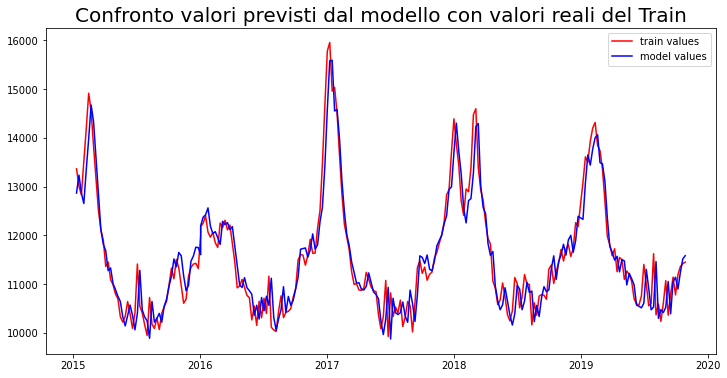

In [16]:
plt.figure(figsize=(12,6))
plt.title('Confronto valori previsti dal modello con valori reali del Train', size=20)
plt.plot (train.iloc[1:], color='red', label='train values')
plt.plot (model_fit.fittedvalues.iloc[1:], color = 'blue', label='model values')

plt.legend()
plt.show()


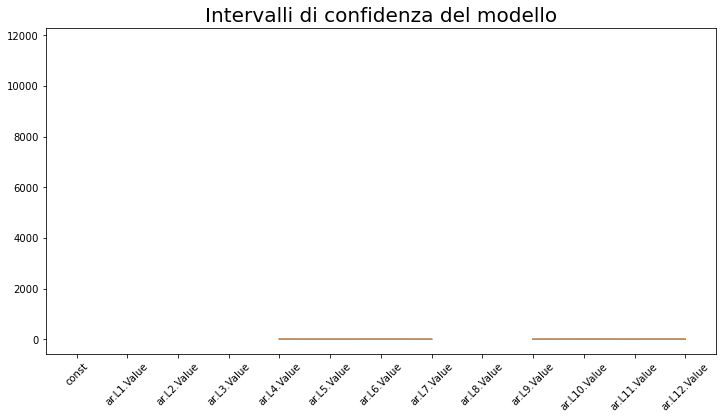

In [17]:
conf = model_fit.conf_int()

plt.figure(figsize=(12,6))
plt.title('Intervalli di confidenza del modello', size=20)
plt.plot(conf)
plt.xticks(rotation=45)
plt.show()

In [18]:
test

TIME
2019-12-02    12253
2019-12-09    12187
2019-12-16    12462
2019-12-23    12621
2019-12-30    12437
Name: Value, dtype: int64

<h3>Predizione del modello sul Test

In [19]:
#inizio e fine predizione
pred_start = test.index[0]
pred_end = test.index[-1]

print(pred_end)
print(pred_start)

2019-12-30 00:00:00
2019-12-02 00:00:00


In [20]:
#inizio e fine predizione
pred_start = test.index[0]
pred_end = test.index[-1]


#predizione del modello sul test
predictions_test= model_fit.predict(start=pred_start, end=pred_end)


plt.figure(figsize=(12,6))
plt.title('Predizione del modello SARIMA sul Test', size=20)
plt.plot(test, color='red', label='actual')
plt.plot(predictions_test, label='prediction' )
plt.xticks(rotation=45)
plt.legend()
plt.show()

print(predictions_test)

KeyError: 'The `start` argument could not be matched to a location related to the index of the data.'

<h3>Calcolo dell'indice RMSE

In [49]:
import numpy as np
from statsmodels.tools.eval_measures import rmse
nrmse = rmse(predictions_test, test)/(np.max(test)-np.min(test))
print('RMSE = ', nrmse)

RMSE =  2.318217716832281


<h2>Predizione del modello compreso l'anno 2020

In [50]:
#inizio e fine predizione
start_prediction = ts.index[0]
end_prediction = ts.index[-1]

predictions_tot = model_fit.predict(start=start_prediction, end=end_prediction)

plt.figure(figsize=(12,6))
plt.title('Previsione modello su dati osservati - dal 2015 al 30 agosto 2020', size=20)
plt.plot(ts, color='blue', label='actual')
plt.plot(predictions_tot.iloc[1:], color='red', label='predict')
plt.xticks(rotation=45)
plt.legend(prop={'size': 12})
plt.show()

KeyError: 'The `end` argument could not be matched to a location related to the index of the data.'

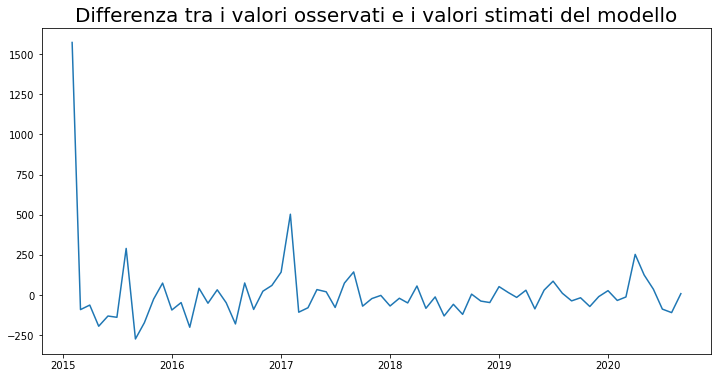

In [38]:
diff_predictions_tot = (ts - predictions_tot)
plt.figure(figsize=(12,6))
plt.title('Differenza tra i valori osservati e i valori stimati del modello', size=20)
plt.plot(diff_predictions_tot)
plt.show()

In [39]:
diff_predictions_tot['24-02-2020':].sum()

215.63209304345878

In [40]:
predictions_tot.to_csv('../../csv/pred/predictions_SARIMA_abruzzo.csv')

<h2>Intervalli di confidenza della previsione totale

In [41]:
forecast = model_fit.get_prediction(start=start_prediction, end=end_prediction)
in_c = forecast.conf_int()
print(forecast.predicted_mean)
print(in_c)
print(forecast.predicted_mean - in_c['lower TOTALE'])

2015-01-31       0.000000
2015-02-28    1558.415276
2015-03-31    1493.177764
2015-04-30    1443.860099
2015-05-31    1319.322304
                 ...     
2020-04-30    1290.797794
2020-05-31    1155.595126
2020-06-30    1185.301257
2020-07-31    1235.011486
2020-08-31    1150.130664
Freq: M, Name: predicted_mean, Length: 68, dtype: float64
            lower TOTALE  upper TOTALE
2015-01-31  -2695.252910   2695.252910
2015-02-28   1204.846931   1911.983620
2015-03-31   1158.741641   1827.613887
2015-04-30   1110.338680   1777.381517
2015-05-31    986.708971   1651.935637
...                  ...           ...
2020-04-30   1045.506535   1536.089054
2020-05-31    910.101662   1401.088591
2020-06-30    934.586903   1436.015610
2020-07-31    983.806418   1486.216554
2020-08-31    898.838219   1401.423109

[68 rows x 2 columns]
2015-01-31    2695.252910
2015-02-28     353.568344
2015-03-31     334.436123
2015-04-30     333.521419
2015-05-31     332.613333
                 ...     
2020-04-3

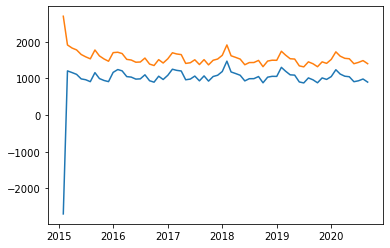

In [42]:
plt.plot(in_c)
plt.show()

In [43]:
upper = in_c['upper TOTALE']
lower = in_c['lower TOTALE']

In [44]:
lower.to_csv('../../csv/lower/predictions_SARIMA_abruzzo_lower.csv')
upper.to_csv('../../csv/upper/predictions_SARIMA_abruzzo_upper.csv')